In [1]:
import os
import random
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import DataLoader
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.to(device)
model.eval()
ds = load_dataset("glue", "sst2")
train_ds = ds["train"]
val_ds   = ds["validation"]
MAX_TRAIN = 20000
MAX_VAL   = 2000
train_ds = train_ds.shuffle(seed=42).select(range(min(MAX_TRAIN, len(train_ds))))
val_ds   = val_ds.select(range(min(MAX_VAL, len(val_ds))))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

2025-12-22 16:16:42.125174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766420202.308297      56 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766420202.364085      56 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766420202.810200      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766420202.810240      56 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766420202.810243      56 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [3]:
def collate_fn(batch):
    texts = [x["sentence"] for x in batch]
    labels = torch.tensor([x["label"] for x in batch], dtype=torch.long)
    enc = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    return enc, labels

batch_size = 64 if device.type == "cuda" else 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

def mean_pool(hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).type_as(hidden_state)
    summed = (hidden_state * mask).sum(dim=1)
    denom = mask.sum(dim=1).clamp(min=1e-6)
    return summed / denom

@torch.no_grad()
def extract_layer_representations(dataloader):
    X_layers = None
    ys = []
    for enc, labels in dataloader:
        enc = {k: v.to(device) for k, v in enc.items()}
        labels = labels.numpy()
        ys.append(labels)
        out = model(**enc)
        hidden_states = out.hidden_states
        if X_layers is None:
            L = len(hidden_states)
            X_layers = [[] for _ in range(L)]
        attn = enc["attention_mask"]
        for li, h in enumerate(hidden_states):
            pooled = mean_pool(h, attn)
            X_layers[li].append(pooled.cpu().numpy())
    X_layers = [np.concatenate(chunks, axis=0) for chunks in X_layers]
    y = np.concatenate(ys, axis=0)
    return X_layers, y

Xtr_layers, ytr = extract_layer_representations(train_loader)
Xva_layers, yva = extract_layer_representations(val_loader)
L = len(Xtr_layers)
H = Xtr_layers[0].shape[1]

In [4]:
def fit_eval_probe(Xtr, ytr, Xva, yva):
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lr", LogisticRegression(max_iter=2000,solver="lbfgs",n_jobs=-1))
    ])
    clf.fit(Xtr, ytr)
    pred = clf.predict(Xva)
    acc = accuracy_score(yva, pred)
    f1  = f1_score(yva, pred)
    return acc, f1, clf, pred

metrics = []
probes = []
preds  = []
for li in range(L):
    acc, f1, clf, pred = fit_eval_probe(Xtr_layers[li], ytr, Xva_layers[li], yva)
    metrics.append((li, acc, f1))
    probes.append(clf)
    preds.append(pred)
    print(f"слой {li:02d}: acc={acc:.4f}, f1={f1:.4f}")
layers = [m[0] for m in metrics]
accs   = [m[1] for m in metrics]
f1s    = [m[2] for m in metrics]

слой 00: acc=0.7729, f1=0.7815
слой 01: acc=0.7775, f1=0.7830
слой 02: acc=0.7741, f1=0.7828
слой 03: acc=0.7844, f1=0.7925
слой 04: acc=0.8062, f1=0.8116
слой 05: acc=0.8028, f1=0.8097
слой 06: acc=0.8222, f1=0.8264
слой 07: acc=0.8245, f1=0.8317
слой 08: acc=0.8475, f1=0.8521
слой 09: acc=0.8521, f1=0.8555
слой 10: acc=0.8601, f1=0.8647
слой 11: acc=0.8532, f1=0.8581
слой 12: acc=0.8498, f1=0.8546


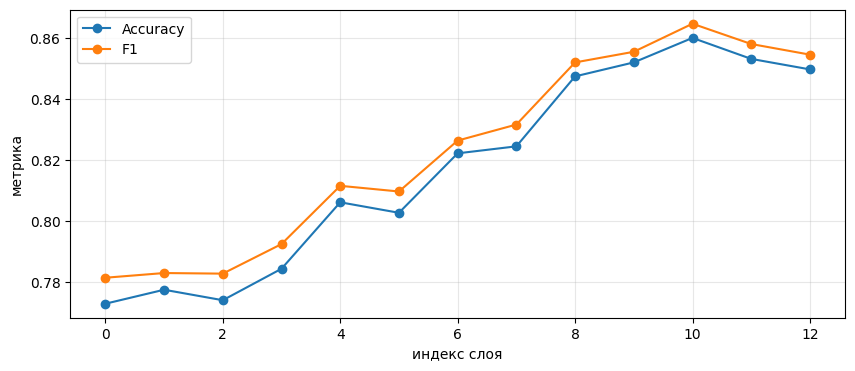

In [5]:
plt.figure(figsize=(10,4))
plt.plot(layers, accs, marker="o", label="Accuracy")
plt.plot(layers, f1s, marker="o", label="F1")
plt.xlabel("индекс слоя")
plt.ylabel("метрика")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [6]:
top3 = sorted(metrics, key=lambda x: x[1], reverse=True)[:3]
print("топ3 слоя:")
for li, acc, f1 in top3:
    print(f"  слой {li:02d}: acc={acc:.4f}, f1={f1:.4f}")
best_layer = top3[0][0]

топ3 слоя:
  слой 10: acc=0.8601, f1=0.8647
  слой 11: acc=0.8532, f1=0.8581
  слой 09: acc=0.8521, f1=0.8555


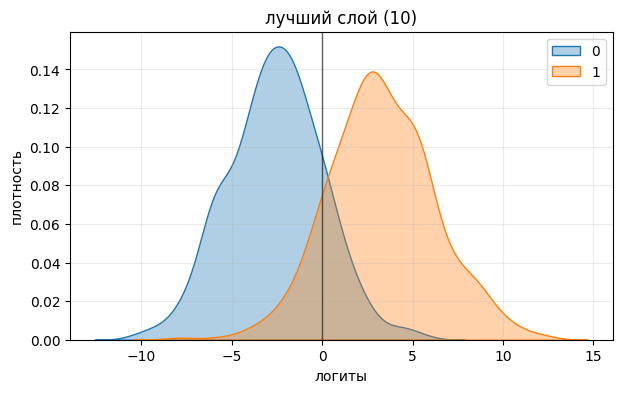

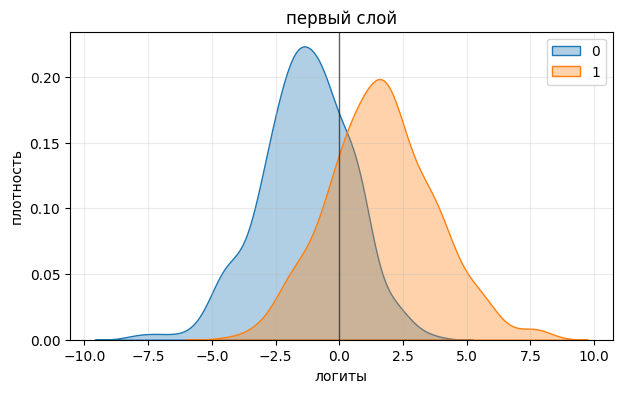

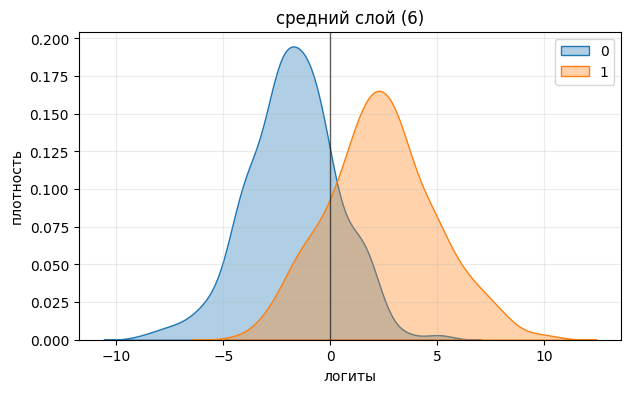

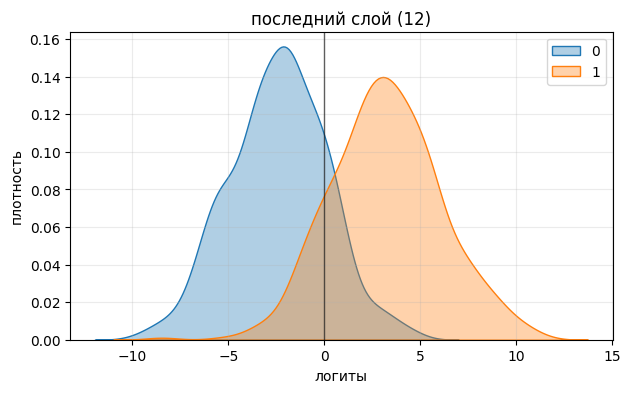

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def probe_score_plot(layer_id, Xva_layers, yva, probes, title=None):
    clf = probes[layer_id]
    scaler = clf.named_steps["scaler"]
    lr = clf.named_steps["lr"]
    Xs = scaler.transform(Xva_layers[layer_id])
    w = lr.coef_.ravel()
    b = float(lr.intercept_.ravel()[0])
    scores = Xs @ w + b

    plt.figure(figsize=(7,4))
    sns.kdeplot(scores[yva==0], label="0", fill=True, alpha=0.35)
    sns.kdeplot(scores[yva==1], label="1", fill=True, alpha=0.35)
    plt.axvline(0.0, color="k", lw=1, alpha=0.6)
    plt.xlabel("логиты")
    plt.ylabel("плотность")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

last_layer = L - 1
first_transformer_layer = 1
mid_transformer_layer = 1 + (last_layer - 1) // 2

probe_score_plot(best_layer, Xva_layers, yva, probes, title=f"лучший слой ({best_layer})")
probe_score_plot(first_transformer_layer, Xva_layers, yva, probes, title=f"первый слой")
probe_score_plot(mid_transformer_layer, Xva_layers, yva, probes, title=f"средний слой ({mid_transformer_layer})")
probe_score_plot(last_layer, Xva_layers, yva, probes, title=f"последний слой ({last_layer})")

Ну начальные слои видим что совсем не очень информативны. Видим определенное монотонное возрастание информативности, однако на самых-самых последниях слоях информативность снижается. Это можно думаю объяснить тем что у нас последнии слои как бы специализированы под задачу на которой обучалась модель, то есть заточенность под конкретный словарь идет. И так как мы в этом задании не дообучаем берт а берем готовый то он не заточен под наш случай и в итоге информативность самых последних слоев снизилась. 